# Model 4

### Target

- Add Regularization, Dropout

### Results

- Parameters : 7,448
- Best Train Accuracy : 98.78
- Best Test Accuracy : 99.01

### Analysis

- Model can be pushed to learn in more epochs
- Model is slightly underfitting and not overfitting as training and test accuracies are closeby.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_mnist_data

In [4]:
train , test = load_mnist_data(train_transforms,test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\Tharun\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


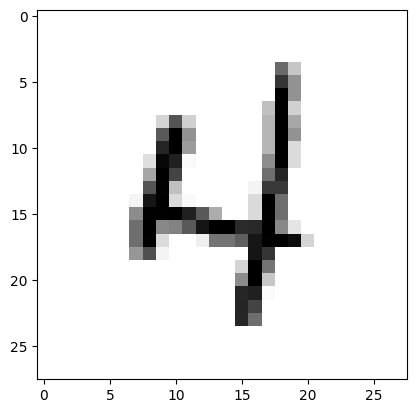

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [7]:
from utils import plot_images

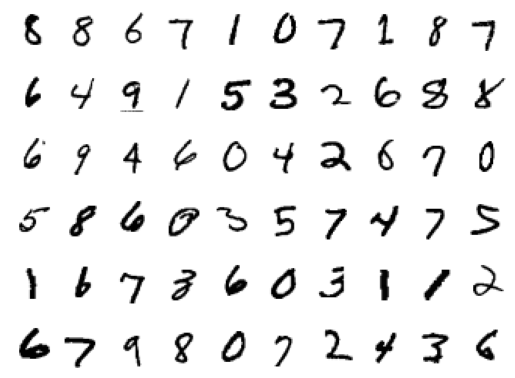

In [8]:
plot_images(images)

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [9]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The Model

Changing Model-3 to adding Dropout , Regularisation

In [10]:
from model import Model4 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
      BatchNorm2d-10            [-1, 8, 24, 24]              16
             ReLU-11            [-1, 8, 24, 24]               0
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

All right, so we have 7,448 params. The purpose of this notebook is to add Dropout's , Regularization between block of Conv Layers.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's import train and test functions from our `model.py` script file

In [12]:
from model import train,test

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch , train_losses , train_acc)
    test(model, device, test_loader ,test_losses , test_acc)

EPOCH: 0


Loss=0.09012945741415024 Batch_id=468 Accuracy=83.75: 100%|██████████████████████████| 469/469 [00:10<00:00, 44.44it/s]



Test set: Average loss: 0.1767, Accuracy: 9513/10000 (95.13%)

EPOCH: 1


Loss=0.16448044776916504 Batch_id=468 Accuracy=96.91: 100%|██████████████████████████| 469/469 [00:08<00:00, 53.11it/s]



Test set: Average loss: 0.1169, Accuracy: 9659/10000 (96.59%)

EPOCH: 2


Loss=0.027766453102231026 Batch_id=468 Accuracy=97.70: 100%|█████████████████████████| 469/469 [00:08<00:00, 54.87it/s]



Test set: Average loss: 0.0601, Accuracy: 9803/10000 (98.03%)

EPOCH: 3


Loss=0.05159689858555794 Batch_id=468 Accuracy=98.06: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.23it/s]



Test set: Average loss: 0.0620, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


Loss=0.04520047828555107 Batch_id=468 Accuracy=98.15: 100%|██████████████████████████| 469/469 [00:08<00:00, 54.44it/s]



Test set: Average loss: 0.0591, Accuracy: 9817/10000 (98.17%)

EPOCH: 5


Loss=0.055899638682603836 Batch_id=468 Accuracy=98.31: 100%|█████████████████████████| 469/469 [00:08<00:00, 54.17it/s]



Test set: Average loss: 0.0443, Accuracy: 9859/10000 (98.59%)

EPOCH: 6


Loss=0.0432807058095932 Batch_id=468 Accuracy=98.53: 100%|███████████████████████████| 469/469 [00:08<00:00, 54.12it/s]



Test set: Average loss: 0.0567, Accuracy: 9806/10000 (98.06%)

EPOCH: 7


Loss=0.0649009719491005 Batch_id=468 Accuracy=98.49: 100%|███████████████████████████| 469/469 [00:08<00:00, 54.51it/s]



Test set: Average loss: 0.0376, Accuracy: 9873/10000 (98.73%)

EPOCH: 8


Loss=0.01049621682614088 Batch_id=468 Accuracy=98.56: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.90it/s]



Test set: Average loss: 0.0486, Accuracy: 9841/10000 (98.41%)

EPOCH: 9


Loss=0.1051793098449707 Batch_id=468 Accuracy=98.64: 100%|███████████████████████████| 469/469 [00:08<00:00, 55.02it/s]



Test set: Average loss: 0.0361, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.00444722780957818 Batch_id=468 Accuracy=98.73: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.93it/s]



Test set: Average loss: 0.0373, Accuracy: 9887/10000 (98.87%)

EPOCH: 11


Loss=0.05849345028400421 Batch_id=468 Accuracy=98.64: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.37it/s]



Test set: Average loss: 0.0442, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.021494410932064056 Batch_id=468 Accuracy=98.67: 100%|█████████████████████████| 469/469 [00:08<00:00, 55.98it/s]



Test set: Average loss: 0.0301, Accuracy: 9901/10000 (99.01%)

EPOCH: 13


Loss=0.03316095098853111 Batch_id=468 Accuracy=98.71: 100%|██████████████████████████| 469/469 [00:08<00:00, 54.82it/s]



Test set: Average loss: 0.0331, Accuracy: 9889/10000 (98.89%)

EPOCH: 14


Loss=0.03200399503111839 Batch_id=468 Accuracy=98.78: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.54it/s]



Test set: Average loss: 0.0325, Accuracy: 9894/10000 (98.94%)



In [14]:
from model import plot_graphs

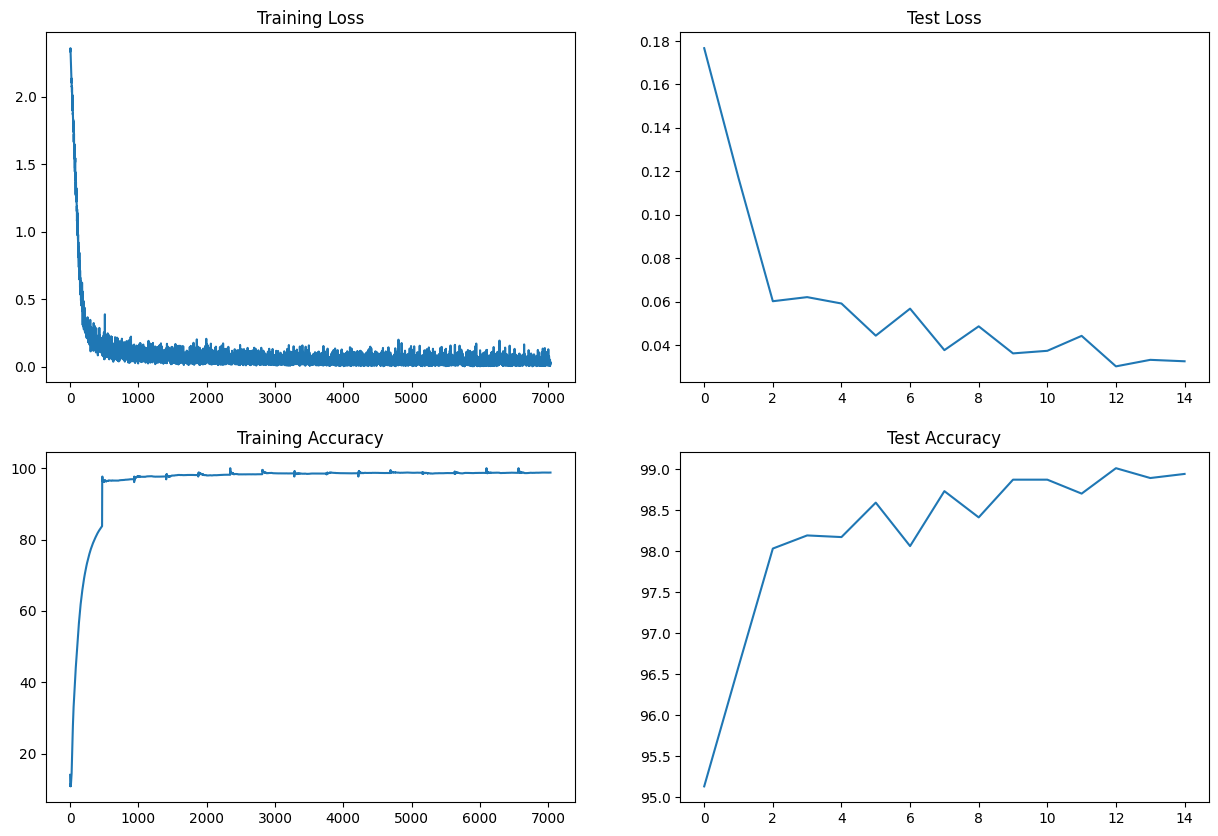

In [15]:
plot_graphs(train_losses , train_acc , test_losses , test_acc)